In [2]:
from statsmodels.tsa.seasonal import seasonal_decompose
import cartopy
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import metpy.calc as mpcalc
import json
import calendar
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature 

import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.util import add_cyclic_point

ModuleNotFoundError: No module named 'statsmodels'

In [3]:
import xarray as xr
import numpy as np
import pandas as pd

In [17]:
import calendar
import json

In [36]:
hgtdata = xr.open_dataset('hgt.mon.mean.nc')
uwnd = xr.open_dataset('uwnd.mon.mean.nc')
vwnd = xr.open_dataset('vwnd.mon.mean.nc')
sst = xr.open_dataset('sst.mnmean.nc')
vento = [uwnd.uwnd, vwnd.vwnd]
coords = [uwnd.variables['lat'][:], uwnd.variables['lon'][:], uwnd.variables['time'][:], uwnd.variables['level'][:]]

/home/lis/anaconda3/envs/bloqueios/lib/python3.8/site-packages/xarray/conventions.py:487: SerializationWarning: variable 'hgt' has multiple fill values {-32767, 32766}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/lis/anaconda3/envs/bloqueios/lib/python3.8/site-packages/xarray/conventions.py:487: SerializationWarning: variable 'uwnd' has multiple fill values {-32767, 32766}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/lis/anaconda3/envs/bloqueios/lib/python3.8/site-packages/xarray/conventions.py:487: SerializationWarning: variable 'vwnd' has multiple fill values {-32767, 32766}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


In [170]:
os.getcwd()
try: 
    os.mkdir("Análises Temporais")
except FileExistsError:
    pass

In [37]:
levels = 850
vorticidade = datasetvort(vento, coords, levels)

/home/lis/anaconda3/envs/bloqueios/lib/python3.8/site-packages/pint/quantity.py:1130: RuntimeWarning: invalid value encountered in true_divide
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)


In [31]:
teste = xr.open_dataset('D:/_Gabriel/Estudo/UFF/Bloqueios_Atmosfericos/Climatologias/nc/GP_79_10.nc')
teste

<xarray.Dataset>
Dimensions:    (latitude: 361, level: 2, longitude: 361, time: 384)
Coordinates:
  * longitude  (longitude) float32 -70.0 -69.75 -69.5 -69.25 ... 19.5 19.75 20.0
  * latitude   (latitude) float32 20.0 19.75 19.5 19.25 ... -69.5 -69.75 -70.0
  * level      (level) int32 700 850
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2010-12-01
Data variables:
    z          (time, level, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2020-03-27 16:48:27 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

In [34]:
dado = teste.sel(level=850).groupby("time.month").mean()#.plot(figsize=(16, 8))

In [42]:
for cada in dado.month:
    cada.values

In [29]:
calendar.month_abbr[1]

'Jan'

In [57]:
def ASAScoords_mes(periodos, level):
    
    hgtdata = xr.open_dataset('D:/_Gabriel/Estudo/UFF/Bloqueios_Atmosfericos/Climatologias/nc/GP_79_10.nc')
    hgt = hgtdata.z
    
    month = np.arange(1, 13)
    for periodo in periodos:
        
        ASAS = {}
        climaASAS = {}
        
        #primeiro, é realizado o recorte dos dados de geopotencial por período e nível. O recorte por período 
        #assume a diferença das coordenadas médias do ASAS para cada intervalo. Após o recorte, os dados são
        #agrupados pela média mensal, como uma climatologia ou levantamento do período.

        dado = hgt.sel(time=slice(periodo[0], periodo[1])).sel(level=level).groupby("time.month").mean()#.plot(figsize=(16, 8))
    
        for i in month:
            
            #Para cada mês, o dado é novamente recortado para a área especificada pelo parâmetro das coordenadas. 
            #Para facilitar a manipulação, o Dataarray é transformado em xr.Dataset
            dataset_OA = dado.sel(latitude=slice(0, -40)).sel(longitude=slice(310, 360)).sel(month=i).to_dataset()
            
            #Este bloco de condições determina qual o limite mínimo (thresh) de altura para qual o ASAS está 
            #sendo proposto. Os valores foram estipulados a partir do valor mínimo entre os máximos de altura
            #geopotencial no Oceano Atlântico, plotados nos gráficos mensais. Assume-se que os valores de 
            #geopotencial máximo correspondem uma possível posição do anticiclone.
            if level == 850:
                if periodo == ["1979-01-01", "1982-12-01"] or periodo == ["1984-01-01", "1990-08-01"]:
                    thresh = 1000
                elif periodo == ["1990-09-01", "2010-01-01"]:
                    thresh = 1000
            elif level == 500:
                if periodo ==["1979-01-01", "2010-12-01"]:
                    thresh = 5860
                elif periodo == ["2010-01-01", "2018-08-01"]:
                    thresh = 5870
                elif periodo == ["2018-09-01", "2020-01-01"]:
                    thresh = 5885
           
            #O dataset é recortado para valores maiores do que o limite.
            rec_dataset_OA = dataset_OA.where(dataset_OA.z>thresh)
            
            #O dataset é transformado em df, onde todos os valores menores que o limite são removidos junto as suas
            #respectivas latitudes e longitudes
            df = rec_dataset_OA.to_dataframe()
            df.dropna(how='any', inplace=True)
            
            #As latitudes e as longitudes médias são calculadas a partir das coordenadas remanescentes
            df.reset_index(inplace=True)  
            latitude_ = df.latitude.mean()
            longitude_ = df.longitude.mean()
            #normdf = normalize(df)
            #valor = normdf.hgt.mean()
            climaASAS.update({calendar.month_abbr[i]:[longitude_, latitude_]})  
            
          #É feita a exportação do arquivo com o formato Mês: [Longitude, Latitude]
 #           if periodo == ["1979-01-01", "2010-12-01"]:
  #              intervalo = "climatologia"
  #          elif periodo == ["2010-01-01", "2018-08-01"] or periodo == ["2018-09-01", "2020-01-01"]:
  #              intervalo = periodo[0][2:4] + " a " + periodo[1][2:4] 
            if periodo == ["1979-01-01", "1982-12-01"] or periodo == ["1984-01-01", "1990-08-01"] or periodo ==["1990-09-01", "2010-01-01"]:
                intervalo = periodo[0][2:4] + ' a ' + periodo[1][2:4]
            with open ('testeASAS_' + str(level) + "_" + intervalo + '.txt', 'w') as json_file:
                json.dump(climaASAS, json_file) 

ASAScoords_mes([["1979-01-01", "1982-12-01"], ["1984-01-01", "1990-08-01"], ["1990-09-01", "2010-01-01"]], level =850)

In [39]:
def ASAScoords(periodo, level):
        
    lons = []
    lats = []
    
    #Seleciona um documento json a partir de um período solicitado como parâmetro, onde cada período possui um
    #conjunto de coordenadas pré determinadas como o ponto médio do ASAS em cada mês
    if periodo == ["1979-01-01", "2010-12-01"]:
        with open('posicaoASAS_' + str(level) + '_climatologia.txt') as clima_file:
            coordsdict = json.load(clima_file)
    elif periodo == ["2010-01-01", "2018-08-01"]:
        with open('posicaoASAS_' + str(level) + '_10 a 18.txt') as deza18_file:
            coordsdict = json.load(deza18_file)
    elif periodo == ["2018-09-01", "2020-01-01"]:
        with open('posicaoASAS_' + str(level) + '_18 a 20.txt') as dezoitoa20_file:
            coordsdict = json.load(dezoitoa20_file)
    
    #As coordenadas do período especificado passam para a lista "coordenadas"
    coordenadas = list(coordsdict.values())
    
    #Para cada um dos meses, a coordenadas máximas e mínimas são retiradas, afim de criar uma região geral de 
    #deslocamento do ASAS 
    for i in range(len(coordenadas)):
        lons.append(coordenadas[i][0])
        lats.append(coordenadas[i][1])
        latitude = [min(lats), max(lats)]
        longitude = [min(lons), max(lons)]
    return latitude, longitude

In [5]:
def coords_scat(periodo, level):
    #Essa função plota um mapa de dispersão das coordenadas do ASAS retiradas do arquivo json exportado pela 
    #função ASAScoords_mes, plotando a média de cada mês para o período e level solicitados
    if periodo == ["1979-01-01", "2010-12-01"]:
        with open('posicaoASAS_' + str(level) + '_climatologia.txt') as clima_file:
            coordsdict = json.load(clima_file)
    elif periodo == ["2010-01-01", "2018-08-01"]:
        with open('posicaoASAS_' + str(level) + '_10 a 18.txt') as deza18_file:
            coordsdict = json.load(deza18_file)
    elif periodo == ["2018-09-01", "2020-01-01"]:
        with open('posicaoASAS_' + str(level) + '_18 a 20.txt') as dezoitoa20_file:
            coordsdict = json.load(dezoitoa20_file)
    
    xs, ys = zip(*coordsdict.values())
    labels = coordsdict.keys()   

    # display
    fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()), figsize=(10, 8))
    ax.add_feature(cartopy.feature.LAND)
    ax.add_feature(cartopy.feature.OCEAN)
    ax.add_feature(cartopy.feature.BORDERS, linestyle=':', edgecolor='gray')

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='black', alpha=0.3, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_left = True
    gl.ylabels_right = False
    gl.ylines = True
    gl.xlines = True
    gl.xlocator = mticker.FixedLocator(np.arange(-180, 200, 10))
    gl.ylocator = mticker.FixedLocator(np.arange(-180, 200, 10))
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10}
    gl.ylabel_style = {'size': 10}

    #ax.stock_img()
    ax.scatter(xs, ys, transform=ccrs.PlateCarree(), label='Estimativa do epicentro do ASAS')
    ax.set_extent([310, 355, -28, -6])         
    ax.coastlines()

    transform = ccrs.PlateCarree()._as_mpl_transform(ax)
    for label, x, y in zip(labels, xs, ys):
        ax.annotate(label, xy = (x, y), xycoords=transform)
    ax.set_title('Máximos do geopotencial entre ' + periodo[0][:4] + " e " + periodo[1][:4] + ' (' + str(level) + 'hPa)', fontsize=15)
    ax.legend()
    plt.show()
    

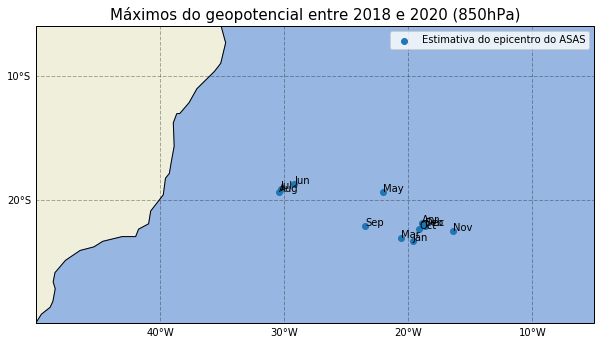

In [30]:
#coords_scat(["1979-01-01", "2010-12-01"], 850)
#coords_scat(["2010-01-01", "2018-08-01"], 850)
coords_scat(["2018-09-01", "2020-01-01"], 850)

In [3]:
def magnitude(uwnd, vwnd, coords):
    magnitude = (uwnd.uwnd**2 + vwnd.vwnd**2)**0.5
    da = xr.DataArray(magnitude,
                      dims=['time', 'level', 'lat', 'lon'],
                      coords={'time': coords[2], 'level': coords[3], 'lat': coords[0], 'lon': coords[1]}, name = 'magnitude do vento').to_dataset(name='magnitude do vento')
    return da
magnitude = magnitude(uwnd,vwnd,coords)

In [9]:
magnitude.attrs['unidade'] = 'm/s'

In [10]:
magnitude

<xarray.Dataset>
Dimensions:             (lat: 73, level: 17, lon: 144, time: 493)
Coordinates:
  * time                (time) datetime64[ns] 1979-01-01 ... 2020-01-01
  * level               (level) float32 1000.0 925.0 850.0 ... 30.0 20.0 10.0
  * lat                 (lat) float32 90.0 87.5 85.0 82.5 ... -85.0 -87.5 -90.0
  * lon                 (lon) float32 0.0 2.5 5.0 7.5 ... 352.5 355.0 357.5
Data variables:
    magnitude do vento  (time, level, lat, lon) float32 1.8104126 ... 1.5027046
Attributes:
    unidade:  m/s

In [40]:
def calculavort(vento, coords, level):
    v = []
    dx, dy = mpcalc.lat_lon_grid_deltas(coords[1], coords[0])
    
    for i, data in enumerate(coords[2]):
        vort = mpcalc.vorticity(vento[0].sel(level=level).isel(time=i), 
                                                vento[1].sel(level=level).isel(time=i),
                                                dx, dy, dim_order='yx')
        v.append(xr.DataArray(vort.m,
                      dims=['lat', 'lon'],
                      coords={'lat': coords[0], 'level':level, 'lon': coords[1], 'time': coords[2][i]}, name = 'vorticidade'))
    vorticidade = xr.concat(v, dim = 'time')
    return vorticidade

def datasetvort(vento, coords, levels):
    vorts = []
    if type(levels) is list:
        pass
    else:
        levels = [levels]
    for level in levels:
        vorts.append(calculavort(vento,coords,level))
    vorticidade = xr.concat(vorts, dim = 'level').to_dataset(name='vorticidade')
    return vorticidade

In [41]:
def calculadiv(vento, coords, level):
    d = []
    dx, dy = mpcalc.lat_lon_grid_deltas(coords[1], coords[0])
    
    for i, data in enumerate(coords[2]):
        div = mpcalc.divergence(vento[0].sel(level=level).isel(time=i), 
                                                vento[1].sel(level=level).isel(time=i),
                                                dx, dy, dim_order='yx')
        d.append(xr.DataArray(div.m,
                      dims=['lat', 'lon'],
                      coords={'lat': coords[0], 'level':level, 'lon': coords[1], 'time': coords[2][i]}, name = 'divergencia'))
    divergencia = xr.concat(d, dim = 'time')
    return divergencia

def datasetdiv(vento, coords, levels):
    divs = []
    if type(levels) is list:
        pass
    else:
        levels = [levels]
    for level in levels:
        divs.append(calculadiv(vento,coords,level))
    divergencia = xr.concat(divs, dim = 'level').to_dataset(name='divergencia')
    return divergencia


/home/lis/anaconda3/envs/bloqueios/lib/python3.8/site-packages/pint/quantity.py:1130: RuntimeWarning: invalid value encountered in true_divide
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)


[-27.738095238095237, -22.5] [334.9568965517241, 348.6764705882353]


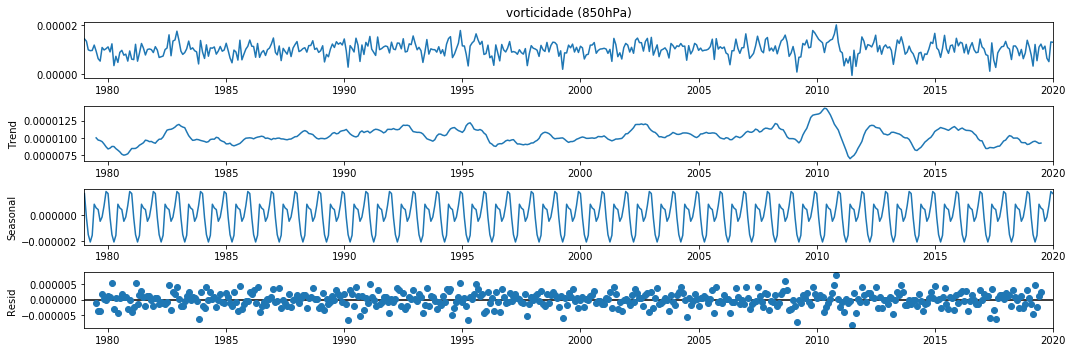

In [28]:
#recebe um xr.dataset e retorna a decomposição temporal da série
def decomposicao_temporal(levels, var, lat, lon, name):
    if type(levels) is list:
        pass
    else:
        levels = [levels]
    for level in levels:
        vardict = {}
        for i in var.data_vars[name].time.values:
            vardict.update({i: np.mean(var.sel(level=level).sel(lat=slice(lat[1], lat[0])).sel(lon=slice(lon[0], lon[1])).sel(time=i)).data_vars[name]})
        df = pd.DataFrame.from_dict(vardict, orient='index', columns=[name + ' (' + str(level)+ 'hPa)'])
        result = seasonal_decompose(df[name + ' (' + str(level)+ 'hPa)'], model='additive')
        plt.rcParams.update({'figure.figsize': (15,5)})
        result.plot()
        path = os.path.join(os.getcwd(), "Análises Temporais", name)
        try:
            os.mkdir(path)
        except FileExistsError:
            pass
        plt.savefig(os.path.join(path, name + "_" + str(level) + ".png"))

periodo = ["2010-01-01", "2018-08-01"]
level = 850
var = datasetvort(vento, coords, level)
name = 'vorticidade'
lat, lon = ASAScoords(periodo, level)
print(lat, lon)
decomposicao_temporal(level, var, lat, lon, name)

In [47]:
def anom_ac(level, var, lat, lon, periodo, periodobase, name):
    anomalia = []
    vardict = {}
    
    antigo = var.sel(level=level).sel(time=periodobase).groupby('time.month').mean()
    atual = var.sel(level=level).sel(time=periodo)
    anomalia.append(antigo-atual)
    
    anomalias = xr.concat(anomalia, dim='level')
    
    for i in anomalias.time.values:
        vardict.update({i: anomalias.sel(time=i).sel(level=level).sel(lat=slice(lat[1], lat[0])).sel(lon=slice(lon[0], lon[1])).mean().data_vars[name]})
    #df = valores de anomalia
    df = pd.DataFrame.from_dict(vardict, orient='index', columns=['anomalia de ' + name + ' (' + str(level)+ 'hPa)'])
    #anomalia acumulada = soma acumulada da média móvel dos valores de anomalia
    ac = np.cumsum(df.rolling(12).mean())
    
    return df, ac

In [48]:
#anomalia
levels = 850
var = datasetdiv(vento, coords, levels)
periodobase = slice("1979-01-01", "2010-01-01")
periodo = slice("2010-01-01", "2020-01-01")

df, ac = anom_ac(level, var, lat, lon, periodo, periodobase, 'divergencia')

/home/lis/anaconda3/envs/bloqueios/lib/python3.8/site-packages/pint/quantity.py:1130: RuntimeWarning: invalid value encountered in true_divide
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)
/home/lis/anaconda3/envs/bloqueios/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [44]:
def anom_easyplot(anom_df, anom_df_cusum):
    fig, ax = plt.subplots(figsize=(15, 10))
    
    anom, = ax.plot(anom_df, label='Anomalia')
    roll, = ax.plot(anom_df.resample("M").mean().rolling(12).mean(), color = 'black', label='Média móvel')
    #plot de nan não afeta o resultado do gráfico, apenas carrega o label que falta para o ax2
    ax.plot(np.nan, '-r', label = 'Anomalia acumulada')  
    
    ax2 = ax.twinx()
    cusum = ax2.plot(anom_df_cusum, color="#FB3640", label = 'Anomalia acumulada')
    ax.legend(loc='upper left')
    
    ax.tick_params(axis='y', colors='#6D9DC5')
    ax2.tick_params(axis='y', colors='#FB3640')

    ax2.grid(None)
    ax.set_title(str(ac.columns)[8:36].capitalize() + 'hPa)')
    
    fig.savefig(str(ac.columns)[8:36].capitalize() + 'hPa) .png')
    return fig, ax

(<Figure size 1080x720 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f68f53c29a0>)

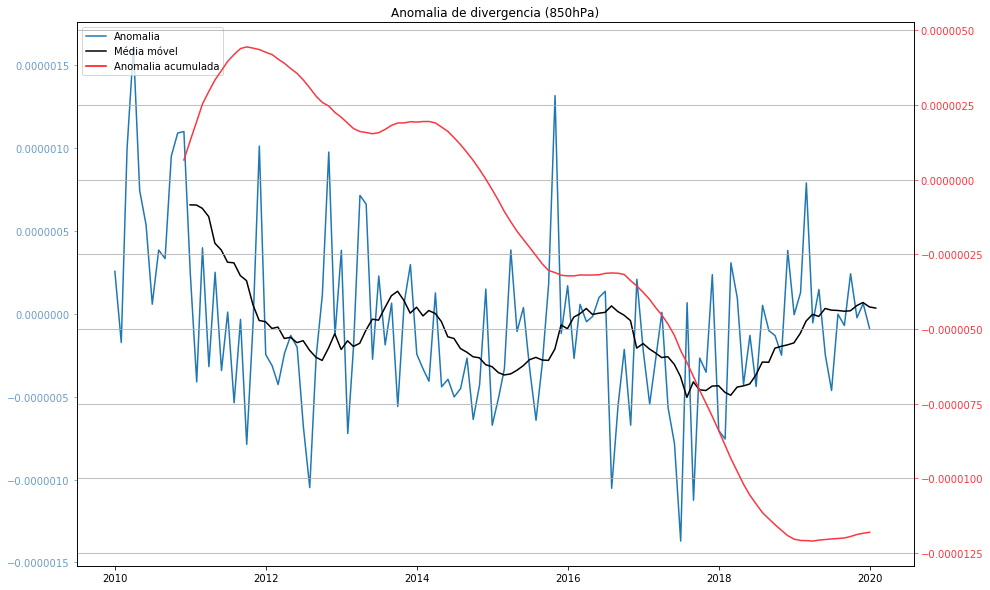

In [49]:
anom_easyplot(df, ac)

In [627]:
vorticidade = datasetvort(vento, coords, levels)

/home/lis/anaconda3/envs/bloqueios/lib/python3.8/site-packages/pint/quantity.py:1130: RuntimeWarning: invalid value encountered in true_divide
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)


In [628]:
divergencia = datasetdiv(vento, coords, levels)

/home/lis/anaconda3/envs/bloqueios/lib/python3.8/site-packages/pint/quantity.py:1130: RuntimeWarning: invalid value encountered in true_divide
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)


In [631]:
vorticidade.to_dataframe().tail(40)

vorticidade
lat   level lon   time                   
-90.0 850   357.5 2016-10-01          NaN
                  2016-11-01          NaN
                  2016-12-01          NaN
                  2017-01-01          NaN
                  2017-02-01          NaN
                  2017-03-01          NaN
                  2017-04-01          NaN
                  2017-05-01          NaN
                  2017-06-01          NaN
                  2017-07-01          NaN
                  2017-08-01          NaN
                  2017-09-01          NaN
                  2017-10-01          NaN
                  2017-11-01          NaN
                  2017-12-01          NaN
                  2018-01-01          NaN
                  2018-02-01          NaN
                  2018-03-01          NaN
                  2018-04-01          NaN
                  2018-05-01          NaN
                  2018-06-01          NaN
                  2018-07-01          NaN
                  2018-08-01          NaN
                  2018-09-01          NaN
                  2018-10-01          NaN
                  2018-11-01          NaN
                  2018-12-01          NaN
                  2019-01-01          NaN
                  2019-02-01          NaN
                  2019-03-01          NaN
                  2019-04-01          NaN
                  2019-05-01          NaN
                  2019-06-01          NaN
                  2019-07-01          NaN
                  2019-08-01          NaN
                  2019-09-01          NaN
                  2019-10-01          NaN
                  2019-11-01          NaN
                  2019-12-01          NaN
                  2020-01-01          NaN